# Demo
Integrating sub-cellular spots into single-cellular spots based on an improved version of TopACT (i.e., pytacs here).

In [1]:
import pytacs
import scanpy as sc

In [2]:
# Step 1. Prepare the snRNA-seq and spRNA-seq data
data_preper = pytacs.AnnDataPreparer(
    sn_adata=sc.read_h5ad('synthesize/ref_snRNA_mouse_kidney_h5ad_Stacked/GSE265819.annotated.final.h5ad'),
    sp_adata=sc.read_h5ad('synthesize/synthetic_data/groundtruth/spatial_0.h5ad'),
    sn_colname_celltype='annotation',
)
print(data_preper)

--- AnnDataPreparer (pytacs) ---
- sn_adata: AnnData object with n_obs × n_vars = 30308 × 42563
    obs: 'batch', 'n_counts', 'mt_proportion', 'old_index', 'cell_type'
    uns: 'annotation_colors', 'batch_colors', 'log1p', 'neighbors', 'pca', 'umap', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log1p'
    obsp: 'connectivities', 'distances'
- sp_adata: AnnData object with n_obs × n_vars = 9216 × 42563
    obs: 'x', 'y', 'cell_type_groundtruth', 'cell_belong_groundtruth', 'old_index'
- sn_adata_withNegativeControl: _UNDEFINED
- normalized: False
--- --- --- --- ---



In [3]:
data_preper = pytacs.AnnDataPreparer(
    sn_adata=sc.pp.subsample(data_preper.sn_adata, fraction=1/4, copy=True),
    sp_adata=sc.read_h5ad('synthesize/synthetic_data/groundtruth/spatial_0.h5ad'),
    sn_colname_celltype='cell_type',
)
print(data_preper)

--- AnnDataPreparer (pytacs) ---
- sn_adata: AnnData object with n_obs × n_vars = 7577 × 42563
    obs: 'batch', 'n_counts', 'mt_proportion', 'old_index', 'cell_type', 'old_index_copy'
    uns: 'annotation_colors', 'batch_colors', 'log1p', 'neighbors', 'pca', 'umap', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log1p'
    obsp: 'connectivities', 'distances'
- sp_adata: AnnData object with n_obs × n_vars = 9216 × 42563
    obs: 'x', 'y', 'cell_type_groundtruth', 'cell_belong_groundtruth', 'old_index'
- sn_adata_withNegativeControl: _UNDEFINED
- normalized: False
--- --- --- --- ---



In [4]:
# Step 2. Train a local classifier
clf = pytacs.SVM(0.75, log1p=True, normalize=True, on_PCs=False)
clf.fit(
    sn_adata=data_preper.sn_adata
)

In [5]:
# Step 3. Integrate spatial spots into single-cell spots
sph = pytacs.SpatialHandler(adata_spatial=data_preper.sp_adata,
                            local_classifier=clf,
                            max_spots_per_cell=30,
                            threshold_adjacent=1.2,
                            allow_cell_overlap=True,
                            )
print(sph)

--- Spatial Handler (pytacs) ---
- adata_spatial: AnnData object with n_obs × n_vars = 9216 × 42563
    obs: 'x', 'y', 'cell_type_groundtruth', 'cell_belong_groundtruth', 'old_index'
- threshold_adjacent: 1.2
- local_classifier: <pytacs.classifier.SVM object at 0x7f53897bfad0>
    + threshold_confidence: 0.75
    + has_negative_control: False
- max_spots_per_cell: 30
- scale_rbf: 1.0
- allow_cell_overlap: True
- filtrations: 0 fitted
- single-cell segmentation:
    + new samples: 0
    + AnnData: _UNDEFINED
--- --- --- --- --- ---



In [ ]:
sph.run_segmentation(
    n_spots_add_per_step=3,
    coverage_to_stop=0.99,
    max_iter=5000,
    verbose=True,
    warnings=False,
    print_summary=True,
)

Iteration 1:
Querying spot 2489 ...
Spot 2489 | confidence: 9.218e-01 | confident total: 1 | class: 5
Classes total: {5: 1}
Coverage: 0.04%
Iteration 6:
Querying spot 1470 ...
Spot 1470 | confidence: 8.867e-01 | confident total: 6 | class: 0
Classes total: {5: 1, 7: 1, 1: 1, 2: 1, 6: 1, 0: 1}
Coverage: 0.26%
Iteration 11:
Querying spot 7140 ...
Spot 7140 | confidence: 9.199e-01 | confident total: 11 | class: 0
Classes total: {5: 2, 7: 1, 1: 1, 2: 1, 6: 2, 0: 3, 4: 1}
Coverage: 0.58%
Iteration 16:
Querying spot 3968 ...
Spot 3968 | confidence: 9.492e-01 | confident total: 16 | class: 5
Classes total: {5: 5, 7: 1, 1: 1, 2: 1, 6: 3, 0: 4, 4: 1}
Coverage: 0.86%
Iteration 21:
Querying spot 7906 ...
Spot 7906 | confidence: 9.444e-01 | confident total: 21 | class: 6
Classes total: {5: 7, 7: 1, 1: 1, 2: 1, 6: 4, 0: 5, 4: 1, 3: 1}
Coverage: 1.07%
Iteration 26:
Querying spot 2602 ...
Spot 2602 | confidence: 9.151e-01 | confident total: 26 | class: 0
Classes total: {5: 7, 7: 1, 1: 2, 2: 1, 6: 5, 

In [7]:
import dill
dill.dump_session('session.Test_on_synthetic_data_version1.1.1_allow_overlap.dill')

In [1]:
# import dill
# dill.load_session('session.Test_on_synthetic_data.dill')

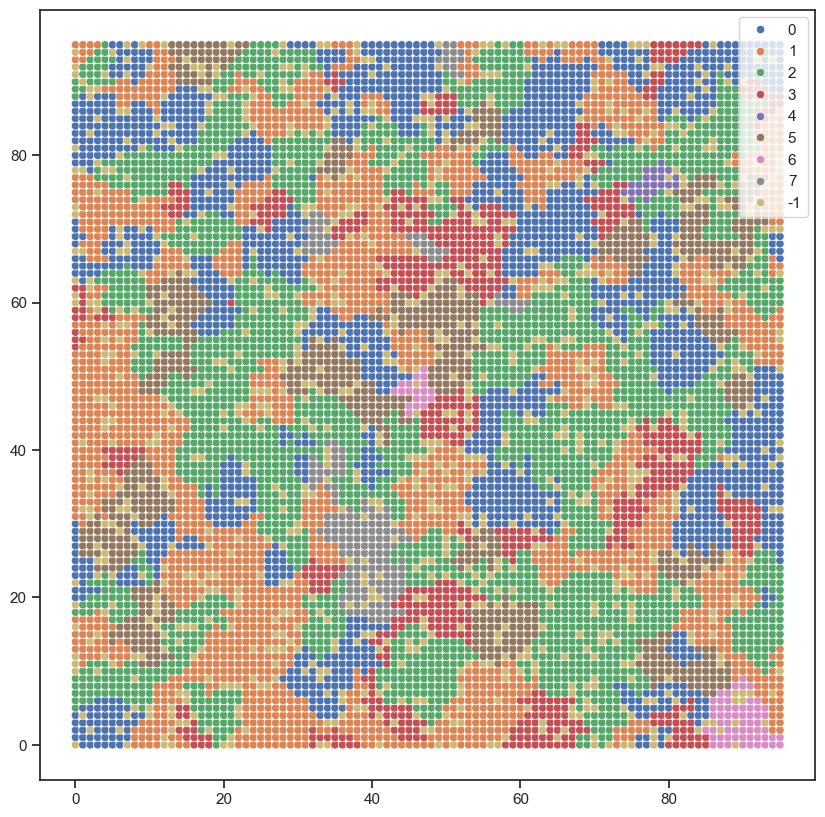

In [2]:
# See the integrated spots
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
sns.set_theme(style='ticks')
sph.run_plotClasses()
plt.show()

In [6]:
# Step 4. Get integrated single-cell level ST data
sp_singleCell = sph.run_getSingleCellAnnData(cache=True, force=True)
print(sp_singleCell)

AnnData object with n_obs × n_vars = 2088 × 42563
    obs: 'x', 'y', 'cell_type_groundtruth', 'cell_belong_groundtruth', 'old_index', 'confidence', 'cell_type'


In [7]:
clf.classes

array(['TAL', 'CCD', 'PT', 'ENDO', 'UROTHELIUM', 'DCT', 'PODS', 'IMMUNE'],
      dtype='<U10')

In [8]:
def get_type_name_by_id(index: int) -> str:
    if index == -1:
        return 'Undefined'
    return clf.classes[index]

In [9]:
sp_singleCell.obs['cell_type_name'] = list(
    map(get_type_name_by_id, sp_singleCell.obs['cell_type'])
)

In [8]:
sp_singleCell.obs

,x,y,cell_type_groundtruth,cell_belong_groundtruth,old_index,confidence,cell_type,cell_type_name
2,0,2,TAL,209,2,0.899650,1,CCD
3,0,3,TAL,209,3,0.855479,1,CCD
4,0,4,TAL,209,4,0.797714,2,PT
6,0,6,PT,144,6,0.832933,2,PT
14,0,14,CCD,57,14,0.753196,2,PT
...,...,...,...,...,...,...,...,...
9203,95,83,CCD,27,9203,0.924104,0,TAL
9208,95,88,ENDO,139,9208,0.929853,0,TAL
9212,95,92,TAL,12,9212,0.857699,2,PT
9214,95,94,TAL,12,9214,0.831008,0,TAL


In [10]:
(sp_singleCell.obs['cell_type_name'] == sp_singleCell.obs['cell_type_groundtruth']).mean()

0.22988505747126436

In [11]:
import numpy as np
spot_types_pred = np.array(list(map(get_type_name_by_id, sph.get_spatial_classes())))
spot_types_truth = data_preper.sp_adata.obs['cell_type_groundtruth'].values

In [12]:
(spot_types_pred == spot_types_truth).mean()

0.7417534722222222

<Axes: xlabel='x', ylabel='y'>

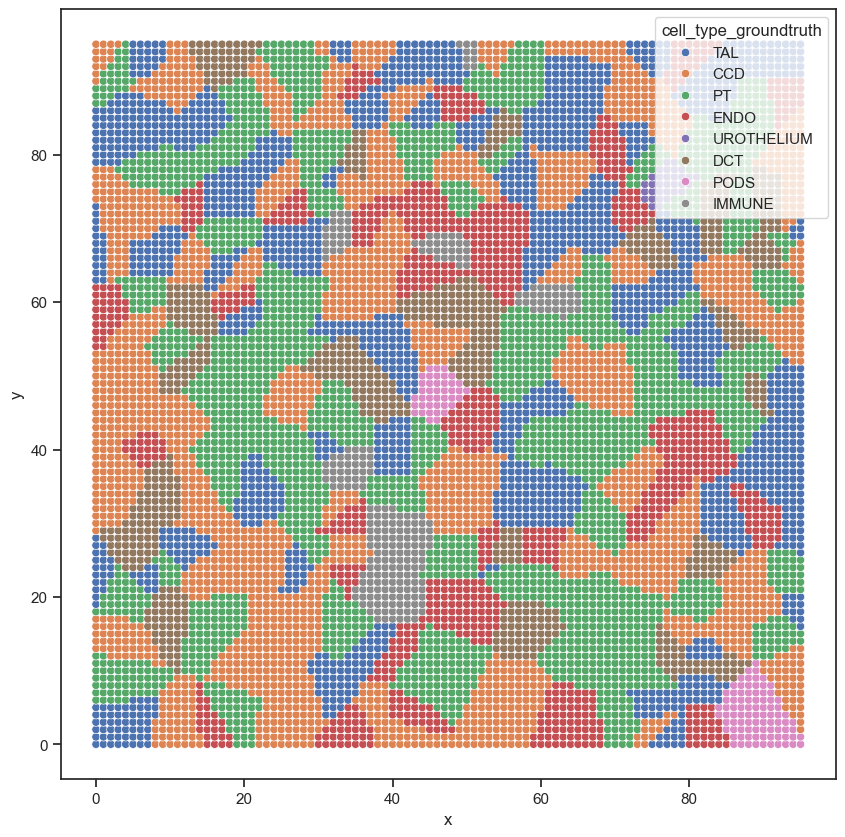

In [3]:
plt.figure(figsize=(10,10))
sns.scatterplot(
    x=data_preper.sp_adata.obs['x'],
    y=data_preper.sp_adata.obs['y'],
    hue=data_preper.sp_adata.obs['cell_type_groundtruth'],
    hue_order=clf.classes
)